In [1]:
import numpy as np
import pandas as pd
import torch
import os
import json
from scripts.RamCol_2  import sdtr_transform2, sdtr_transform2_reverse

from scripts.create_data.TableNumerical import (InternEncoder_Inverse, InternEncoder, EntireEncoder, generate_dataframe,
                                                EntireEncoder_Inverse, ParentChildEncoder, ParentChildEncoder_Inverse)


seed = 3
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.set_device(0)  # 指定GPU设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    
def run(model_type,data_path, epochs, lr, diffusion_steps):
    """
    不同不同数据集+不同方法，需要
    修改： model_type  +  表格生成代码 + SDTR 方法--构造数据 + SDTR 方法--解析数据
    """



    epochs = epochs
    lr = lr
    """
    =========================================================================
     0. Data  
    =========================================================================
    """
    # Unet 一定要DimTrans 才能用
    experiments = 'Table2'
    results_path = 'results/'+model_type+'/'+experiments
    if not os.path.exists(results_path): # 检查并创建results文件夹（包括所有必要的中间文件夹）
        os.makedirs(results_path)



    df = pd.read_csv(data_path)  # 读取CSV文件

    if "Table2" in experiments:
        with open(data_path.replace('.csv', '_subclass_mapping.json')) as f:
            subclass_mapping = json.load(f)
        with open(data_path.replace('.csv', '_parent_child_mapping.json')) as f:
            parent_child_mapping = json.load(f)

    # 编码方式
    if "Intern" in model_type:
        df, intern_encoder = InternEncoder(df)  # 每一列单独编码
    elif "Entire" in model_type:
        df, entire_encoder, vocab_per_column = EntireEncoder(df)
    elif "ParentChild" in model_type:
        df, parent_child_encoder, label_encoder_list = ParentChildEncoder(df, parent_child_mapping, subclass_mapping)  # 父子类编码


    num_rows, num_columns = df.shape
    print(f"原始数据集的表格尺寸为{num_rows}x{num_columns}")
    column_names, train_raw = df.columns, df.values  # 获取列名和数据
    new_dataset_pd = df.copy()
    batch_size = 32*3  # 3 channel for each column




    if 'DimTrans' in model_type:
        channels = 3

    if "RamCol_2" in model_type:  # SDTR 方法 --- 构造数据
        repeat = 2
        # df_torch = torch.from_numpy(df.to_numpy())
        new_dataset_matrix, new_dataset_index = sdtr_transform2(df, repeat, subclass_mapping, parent_child_mapping)  # 100x12
        new_dataset_pd = pd.DataFrame(new_dataset_matrix.detach().numpy())
        channels = 1
        # orgin_df = sdtr_transform2_reverse(new_dataset_matrix, new_dataset_index)

    if "RamCol_1" in model_type:  # SDTR 方法 --- 构造数据
        repeat = 2
        num_columns = num_columns * repeat  #
        df_torch = torch.from_numpy(df.to_numpy())
        from scripts.SDTR import sdtr_transform
        new_dataset_matrix, new_dataset_index = sdtr_transform(df_torch, num_columns)  # 100x12
        new_dataset_pd = pd.DataFrame(new_dataset_matrix.detach().numpy())
        channels = 1

    num_columns = new_dataset_pd.shape[1]



    # 增加一列label，用于标记不同行的数据， 即如果在df中出现一行数据是[a, a1, c, c1]，则label为0, 以此类推
    new_dataset_pd["label"] = new_dataset_pd.groupby(new_dataset_pd.columns.tolist()).ngroup()
    num_class_embeds = len(new_dataset_pd["label"].unique())


    from scripts.ReadTable import read_table
    num_scaler, dataloader = read_table(df=new_dataset_pd, batch_size=batch_size)

    """
    =========================================================================
    1. Model
    =========================================================================
    """
    from model.MLPSynthesizer import MLPSynthesizer  # MLP synthesizer model
    from model.TransSynthesizer import TransSynthesizer  # Transformer synthesizer model
    from model.UnetSynthesizer import UnetSynthesizer  # Unet synthesizer model
    from model.BaseDiffusion import BaseDiffuser

    if 'MLP' in model_type:
        synthesizer_model = MLPSynthesizer(d_in=num_columns, num_class_embeds=num_class_embeds,
                                           hidden_layers=[128, 64, 128], activation='lrelu', dim_t=64, model_type='MLP')
    if 'Unet' in model_type:
        synthesizer_model = UnetSynthesizer(d_in=num_columns,
                                            num_class_embeds=num_class_embeds,
                                            dim_t = 64, channels=channels, model_type='Unet')   # 空间维度转换方法

    diffuser_model = BaseDiffuser(total_steps=diffusion_steps, beta_start=1e-4, beta_end=0.02,device=device,
                                  scheduler='linear')  # initialize the FinDiff base diffuser model
    synthesizer_model = synthesizer_model.to(device)

    """
    =========================================================================
    2. Training
    =========================================================================
    """
    model_params_file = results_path+'/params.json'
    model_weights_file = results_path+'/weights.pth'

    from scripts.Train import train_diffusion_model
    train_epoch_losses = train_diffusion_model(dataloader, synthesizer_model, diffuser_model, device=device,
                                               epochs = epochs, learning_rate = lr, )
    if True:
        from evaluation.LossCurve import visualization_loss_curve
        visualization_loss_curve(train_epoch_losses, savepath=results_path + '/TrainingEpochs_vs_MSEError.png')
        from scripts.Train import save_model_and_params
        save_model_and_params(synthesizer_model, diffuser_model, model_params_file, model_weights_file)  # 保存模型和超参数
    
        from scripts.Train import load_model_and_params
        synthesizer_model, diffuser_model = load_model_and_params(model_params_file, model_weights_file, device=device)  # 加载模型和超参数
        synthesizer_model = synthesizer_model.to(device)

    """
    =========================================================================
    3.  Generate Data
    =========================================================================
    """
    from scripts.Generate import generate_diffusion_model  # 生成数据 batch_size 必须是3的倍数
    z_norm_upscaled = generate_diffusion_model(num_columns, num_scaler,  synthesizer_model, diffuser_model, device=device,
                                               num_class_embeds=num_class_embeds,
                                               n_samples=batch_size*10, batch_size=batch_size, sample_diffusion_steps=diffusion_steps,
                                            )
    if "RamCol_1" in model_type:
        # SDTR 方法 - - -  解析数据
        from scripts.SDTR import sdtr_inverse_transform
        z_norm_upscaled = sdtr_inverse_transform(z_norm_upscaled, new_dataset_index)  # 1000x4
    elif "RamCol_2" in model_type:
        # SDTR 方法 - - -  解析数据
        z_norm_upscaled = sdtr_transform2_reverse(z_norm_upscaled, new_dataset_index)

    samples = pd.DataFrame(z_norm_upscaled, columns=column_names)  # convert generated samples to dataframe
    samples = samples.round(0).astype(int)  # round the generated samples to integers
    samples = samples.astype('category')
    samples.to_csv(results_path+'/samples_undecode.csv', index=False)




    """
    =========================================================================
    4. Evaluation : Generate Data
    =========================================================================
    """
    if "Intern" in model_type:  # 每一列单独编码的解码
        samples = InternEncoder_Inverse(samples, intern_encoder)
        df = InternEncoder_Inverse(df, intern_encoder)
    elif "Entire" in model_type:
        samples = EntireEncoder_Inverse(samples, entire_encoder)  # 解码
        df = EntireEncoder_Inverse(df, entire_encoder)  # 解码
    elif "ParentChild" in model_type:
        samples = ParentChildEncoder_Inverse(samples, parent_child_encoder, subclass_mapping, label_encoder_list)  # 父子类解码
        df = ParentChildEncoder_Inverse(df, parent_child_encoder, subclass_mapping, label_encoder_list)
    samples.to_csv(results_path+'/samples_values.csv', index=False)

    from evaluation.Ratio_Difference import ratio_difference
    average_difference = ratio_difference(df, samples, savepath=results_path+'/ratio_difference.txt')

    if "Table2" in experiments:
        from evaluation.Subclass_Error_Rate import subclass_error_rate
        error_rate, error_count = subclass_error_rate(samples, subclass_mapping, parent_child_mapping, savepath=results_path+'/subclass_error_rate.txt')

    from evaluation.SVDevaluation import svd_evaluation
    Column_Shapes, Column_Pair_Trends = svd_evaluation(real_data=df, synthetic_data=samples, savepath=results_path+'/svd_evaluation')


    return average_difference, Column_Shapes, Column_Pair_Trends, error_rate, error_count


In [2]:


# method_list_Intern = [
#     "Diffusion_MLP_Intern",
#     "RamCol_1_MLP_Intern",
#     "RamCol_2_MLP_Intern",
#     "RamCol_1_Unet_Intern",
#     "RamCol_2_Unet_Intern",
#     "DimTrans_Unet_Intern",
#     "RamCol_1+DimTrans_Unet_Intern",
#     "RamCol_2+DimTrans_Unet_Intern",
# ]
# method_list_Entire = [
#     "Diffusion_MLP_Entire",
#     "RamCol_1_MLP_Entire",
#     "RamCol_2_MLP_Entire",
#     "RamCol_1_Unet_Entire",
#     "RamCol_2_Unet_Entire",
#     "DimTrans_Unet_Entire",
#     "RamCol_1+DimTrans_Unet_Entire",
#     "RamCol_2+DimTrans_Unet_Entire",
# ]

method_list_ParentChild = [
    "Diffusion_MLP_ParentChild",
    "RamCol_1_MLP_ParentChild",
    "RamCol_2_MLP_ParentChild",
    "RamCol_1_Unet_ParentChild",
    "RamCol_2_Unet_ParentChild",
    "DimTrans_Unet_ParentChild",
    "RamCol_1+DimTrans_Unet_ParentChild",
    "RamCol_2+DimTrans_Unet_ParentChild",
]

from scripts.create_data.Table2 import create_table_2
num_rows = 1000
num_columns = 20 # Table2 : 生成2倍num_columns的列数   ;  Table1 : 生成num_columns列
num_categories = 8
num_categories_child = 4
experiments = 'Table2'
data_path = f"data/CDI_Table2.csv"
epochs =20
lr = 1e-3
diffusion_steps=700


| 方法 | num_rows|num_columns |num_categories|num_categories_child  |epochs|  diffusion_steps      | 列比例差异均值  | fidelity Column | fidelity row  |    错误分类率 |   错误数量 |
| --------|------- | --------------- | --------------- | -------------- |-------------- |------ |------ |------ |------ |------ |-------------- |


In [3]:
import sys  
import io  
from contextlib import redirect_stdout, redirect_stderr 

f_out = io.StringIO()   # 使用一个 StringIO 对象来捕获输出  
f_err = io.StringIO()  


In [4]:

print("| 方法 | num_rows|num_columns |num_categories|num_categories_child  |epochs|  diffusion_steps      | 列比例差异均值  | fidelity Column | fidelity row  |    错误分类率 |   错误数量 |")
print("| --------|------- | --------------- | --------------- | -------------- |-------------- |------ |------ |------ |------ |------ |-------------- |")

for model_type in method_list_Intern:
    with redirect_stdout(f_out), redirect_stderr(f_err): 
        average_difference, Column_Shapes, Column_Pair_Trends, error_rate, error_count=run(model_type,data_path, epochs, lr,diffusion_steps)
    print(f"| {model_type} |{num_rows}|{num_columns}|{num_categories}|{num_categories_child}|{epochs}|{diffusion_steps}| {average_difference:.4f} | {Column_Shapes:.4f} | {Column_Pair_Trends:.4f} | {error_rate:.4f} | {error_count} |")


In [5]:

print("| 方法 | num_rows|num_columns |num_categories|num_categories_child  |epochs|  diffusion_steps      | 列比例差异均值  | fidelity Column | fidelity row  |    错误分类率 |   错误数量 |")
print("| --------|------- | --------------- | --------------- | -------------- |-------------- |------ |------ |------ |------ |------ |-------------- |")

for model_type in method_list_Entire:
    with redirect_stdout(f_out), redirect_stderr(f_err): 
        average_difference, Column_Shapes, Column_Pair_Trends, error_rate, error_count=run(model_type,data_path, epochs, lr,diffusion_steps)
    print(f"| {model_type} |{num_rows}|{num_columns}|{num_categories}|{num_categories_child}|{epochs}|{diffusion_steps}| {average_difference:.4f} | {Column_Shapes:.4f} | {Column_Pair_Trends:.4f} | {error_rate:.4f} | {error_count} |")


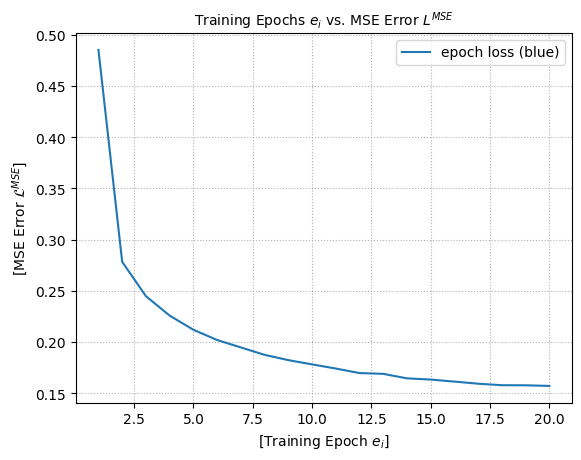

| RamCol_2_Unet_ParentChild |1000|20|8|4|20|700| 0.0840 | 0.8908 | 0.8742 | 0.0573 | 55 |


In [6]:

print("| 方法 | num_rows|num_columns |num_categories|num_categories_child  |epochs|  diffusion_steps      | 列比例差异均值  | fidelity Column | fidelity row  |    错误分类率 |   错误数量 |")
print("| --------|------- | --------------- | --------------- | -------------- |-------------- |------ |------ |------ |------ |------ |-------------- |")

for model_type in method_list_ParentChild:
    with redirect_stdout(f_out), redirect_stderr(f_err): 
        average_difference, Column_Shapes, Column_Pair_Trends, error_rate, error_count=run(model_type,data_path, epochs, lr,diffusion_steps)
    print(f"| {model_type} |{num_rows}|{num_columns}|{num_categories}|{num_categories_child}|{epochs}|{diffusion_steps}| {average_difference:.4f} | {Column_Shapes:.4f} | {Column_Pair_Trends:.4f} | {error_rate:.4f} | {error_count} |")
